# Notebook 2: Making Predictions

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [2]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !pip install pymc3
    !pip install arviz

In [3]:
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## When do we get to inference?

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `4`.

And instead of calling `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `mu`.

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
alpha = 4.4
beta = 1.8

In [7]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  We can plot the posterior using a function provided by PyMC:

In [8]:
len(trace['mu'])

2000

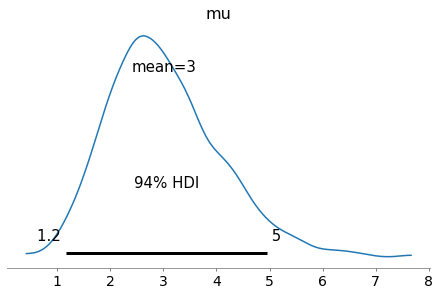

In [9]:
import arviz as az

with model:
    az.plot_posterior(trace)

We can extract a sample of `mu` from the trace.

In [10]:
sample_post_pymc = trace['mu']
np.mean(sample_post_pymc)

3.0185328342487505

In [12]:
import pandas as pd

def make_pmf(sample):
    return pd.Series(sample).value_counts(normalize=True, sort=False).sort_index()

In [13]:
def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    pmf = make_pmf(sample)
    cdf = pmf.cumsum()
    plt.plot(cdf.index, cdf.values, **options)

In [15]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

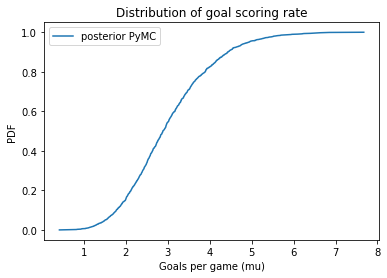

In [16]:
plot_cdf(sample_post_pymc, label='posterior PyMC')
decorate_rate()

## Posterior predictive

To sample from the posterior predictive distribution, we can use `sample_posterior_predictive`:

In [17]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=2000)

Here's what it looks like:

In [18]:
sample_post_pred_pymc = post_pred['goals']
np.mean(sample_post_pred_pymc)

2.989

In [21]:
def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    plt.legend()

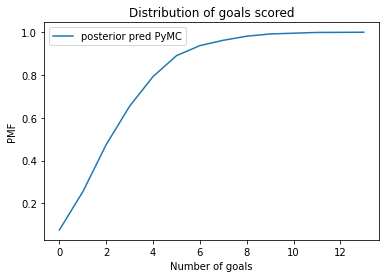

In [22]:
plot_cdf(sample_post_pred_pymc, label='posterior pred PyMC')
decorate_goals()

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [23]:
model = pm.Model()

with model:
    mu_BOS = pm.Gamma('mu_BOS', alpha, beta)
    mu_TBL = pm.Gamma('mu_TBL', alpha, beta)
    goals_BOS = pm.Poisson('goals_BOS', mu_BOS, observed=[3,3])
    goals_TBL = pm.Poisson('goals_TBL', mu_TBL, observed=[3,2])
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_TBL, mu_BOS]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


We can use `traceplot` to review the results and do some visual diagnostics.

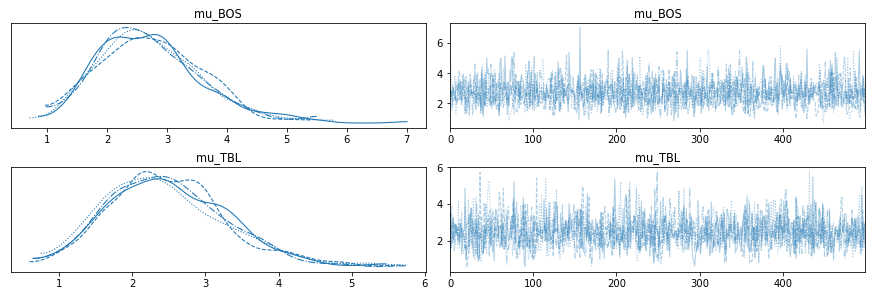

In [24]:
with model:
    az.plot_trace(trace);

Here are the posterior distribitions for `mu_BOS` and `mu_TBL`.

(2.7162147298279606, 2.485548814069198)

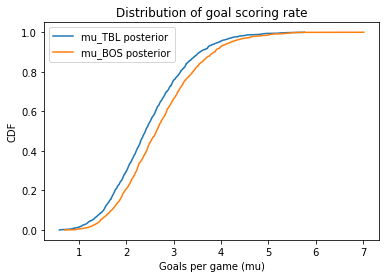

In [25]:
mu_TBL = trace['mu_TBL']
plot_cdf(mu_TBL, label='mu_TBL posterior')

mu_BOS = trace['mu_BOS']
plot_cdf(mu_BOS, label='mu_BOS posterior')

decorate_rate('CDF')
np.mean(mu_BOS), np.mean(mu_TBL)

On the basis of these two games, here's the probability that Boston is the better team.

In [26]:
np.mean(mu_BOS > mu_TBL)

0.5705

In [27]:
np.mean(mu_BOS == mu_TBL)

0.0

## Predictions

Even if Boston is the better team, that doesn't mean they'll win the next game.

We can use `sample_posterior_predictive` to generate predictions.

In [28]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=2000)

Here are the posterior predictive distributions of goals scored.

In [29]:
goals_BOS = post_pred['goals_BOS'].flatten()
goals_TBL = post_pred['goals_TBL'].flatten()

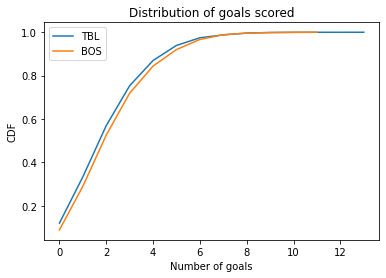

In [30]:
plot_cdf(goals_TBL, label='TBL')
plot_cdf(goals_BOS, label='BOS')
decorate_goals('CDF')

Here's the chance that Boston wins the next game.

In [31]:
win = np.mean(goals_BOS > goals_TBL)
win

0.44725

The chance that they lose.

In [32]:
lose = np.mean(goals_TBL > goals_BOS)
lose

0.38575

And the chance of a tie.

In [33]:
tie = np.mean(goals_BOS == goals_TBL)
tie

0.167

In [ ]:
TODO: Predict overtime

## Going hierarchical

So far, all of this is based on a gamma prior.  To choose the parameters of the prior, I used data from previous Stanley Cup finals and computed a maximum likelihood estimate (MLE).  But that's not correct, because

1. It assumes that the observed goal counts are the long-term goal-scoring rates.
2. It treats `alpha` and `beta` as known values rather than parameters to estimate.

In other words, I have ignored two important sources of uncertainty.  As a result, my predictions are almost certainly too confident.

The solution is a hierarchical model, where `alpha` and `beta` are the parameters that control `mu` and `mu` is the parameter that controls `goals`.  Then we can use observed `goals` to update the distributions of all three unknown parameters.

Of course, now we need a prior distribution for `alpha` and `beta`.  A common choice is the half Cauchy distribution (see [Gelman](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf)), but on advice of counsel, I'm going with exponential.

Here's a PyMC model that generates `alpha` and `beta` from an exponential distribution.

In [82]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    trace = pm.sample_prior_predictive(1000)

Here's what the distributions of `alpha` and `beta` look like.

0.994078101660476

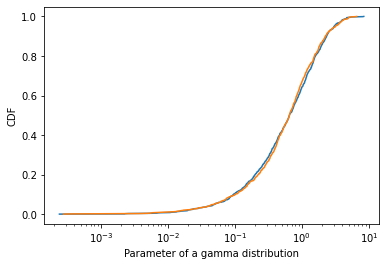

In [83]:
sample_prior_alpha = trace['alpha']
plot_cdf(sample_prior_alpha, label='alpha prior')
sample_prior_beta = trace['beta']
plot_cdf(sample_prior_beta, label='beta prior')

plt.xscale('log')
plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
np.mean(sample_prior_alpha)

Now that we have `alpha` and `beta`, we can generate `mu`.

In [86]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    trace = pm.sample_prior_predictive(1000)

Here's what the prior distribution of `mu` looks like.

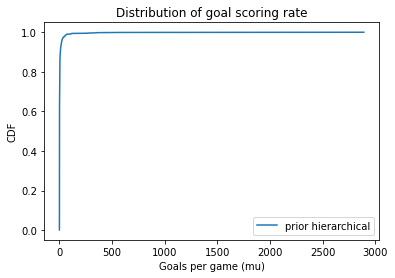

In [87]:
sample_prior_mu = trace['mu']
plot_cdf(sample_prior_mu, label='prior hierarchical')
decorate_rate('CDF')
np.mean(sample_prior_mu)

In effect, the model is saying "I have never seen a hockey game before.  As far as I know, it could be soccer, could be basketball, could be pinball."

If we zoom in on the range 0 to 10, we can compare the prior implied by the hierarchical model with the gamma prior I hand picked.

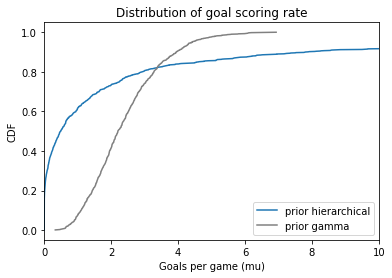

In [88]:
plot_cdf(sample_prior_mu, label='prior hierarchical')
plot_cdf(sample_prior_gamma, label='prior gamma', color='gray')
plt.xlim(0, 10)
decorate_rate('CDF')

Obviously, they are very different.  They agree that the most likely values are less than 10, but the hierarchical model admits the possibility that `mu` could be orders of magnitude bigger.

Strange as it sounds, that's probably what we want in a non-committal prior.

Ok, last step of the forward process, let's generate some goals.

In [89]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

/home/downey/anaconda3/envs/BayesianInferencePyMC/lib/python3.9/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


Here's the prior predictive distribution of goals.

In [90]:
sample_prior_goals = trace['goals']

5.957

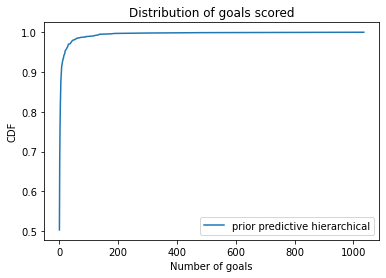

In [92]:
plot_cdf(sample_prior_goals, label='prior predictive hierarchical')
decorate_goals('CDF')
np.mean(sample_prior_goals)

To see whether that distribution is right, I ran samples using SciPy.

In [93]:
import scipy.stats as st

def forward_hierarchical(size=1):
    alpha = st.expon().rvs(size=size)
    beta = st.expon().rvs(size=size)
    mu = st.gamma(a=alpha, scale=1/beta).rvs(size=size)
    goals = st.poisson(mu).rvs(size=size)
    return goals[0]

sample_prior_goals_st = [forward_hierarchical() for i in range(1000)];

103.971

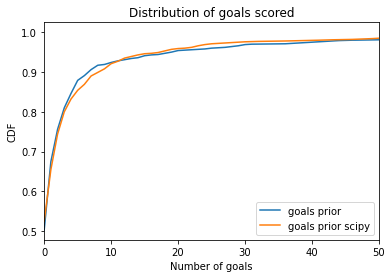

In [95]:
plot_cdf(sample_prior_goals, label='goals prior')
plot_cdf(sample_prior_goals_st, label='goals prior scipy')
decorate_goals('CDF')
plt.xlim(0, 50)
plt.legend(loc='lower right')
np.mean(sample_prior_goals_st)

## Hierarchical inference

Once we have the forward process working, we only need a small change to run the reverse process.

In [97]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=[3, 3])
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


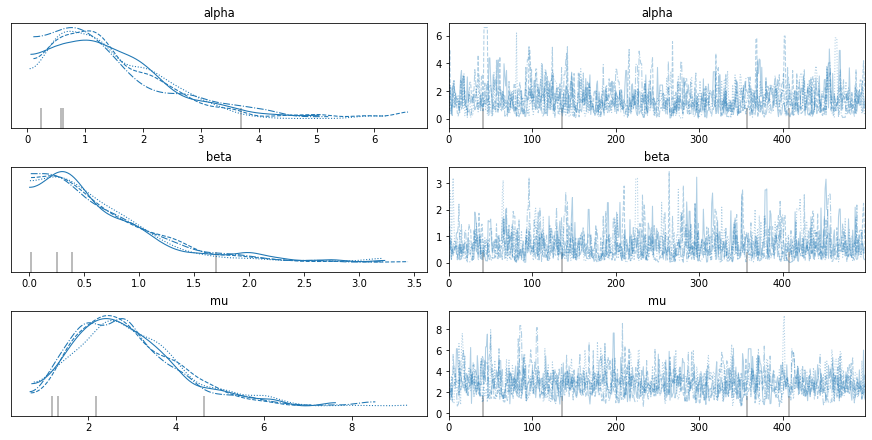

In [98]:
with model:
    az.plot_trace(trace)

Here's the posterior distribution of `mu`.  The posterior mean is close to the observed value, which is what we expect with a weakly informative prior.

2.9191663535416104

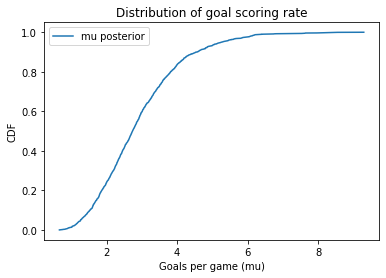

In [99]:
sample_post_mu = trace['mu']
plot_cdf(sample_post_mu, label='mu posterior')
decorate_rate('CDF')
np.mean(sample_post_mu)

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [101]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_BOS = pm.Gamma('mu_BOS', alpha, beta)
    mu_TBL = pm.Gamma('mu_TBL', alpha, beta)
    goals_BOS = pm.Poisson('goals_BOS', mu_BOS, observed=[3, 3])
    goals_TBL = pm.Poisson('goals_TBL', mu_TBL, observed=[2, 3])
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_TBL, mu_BOS, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6944037391596013, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


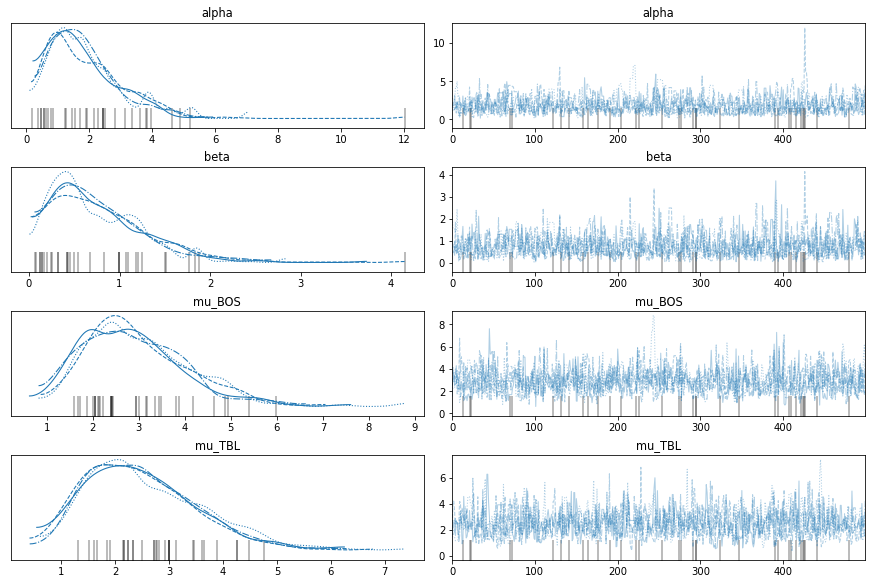

In [102]:
with model:
    az.plot_trace(trace)

Here are the posterior distribitions for `mu_TBL` and `mu_BOS`.

(2.500703327045398, 2.92187325733346)

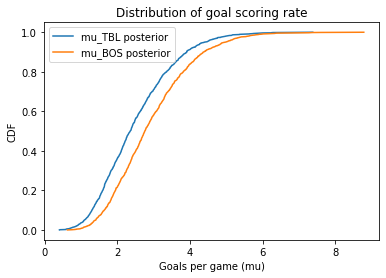

In [104]:
sample_post_mu_TBL = trace['mu_TBL']
plot_cdf(sample_post_mu_TBL, label='mu_TBL posterior')

sample_post_mu_BOS = trace['mu_BOS']
plot_cdf(sample_post_mu_BOS, label='mu_BOS posterior')

decorate_rate('CDF')
np.mean(sample_post_mu_TBL), np.mean(sample_post_mu_BOS)

On the basis of one game (and never having seen a previous game), here's the probability that Boston is the better team.

In [105]:
np.mean(sample_post_mu_BOS > sample_post_mu_TBL)

0.6175

## More background

But let's take advantage of more information.  Here are the results from the seven most recent Stanley Cup finals, ignoring games that went into overtime.

In [106]:
data = dict(BOS13 = [2, 1, 2],
            CHI13 = [0, 3, 3],
            NYR14 = [0, 2],
            LAK14 = [3, 1],
            TBL15 = [1, 4, 3, 1, 1, 0],
            CHI15 = [2, 3, 2, 2, 2, 2],
            SJS16 = [2, 1, 4, 1],
            PIT16 = [3, 3, 2, 3],
            NSH17 = [3, 1, 5, 4, 0, 0],
            PIT17 = [5, 4, 1, 1, 6, 2],
            VGK18 = [6, 2, 1, 2, 3],
            WSH18 = [4, 3, 3, 6, 4],
            BOS19 = [2, 7, 2, 1, 5, 1],
            STL19 = [2, 2, 4, 2, 1, 4],
            BOS20 = [3, 2],
            TBL20 = [2, 3],
           )

Here's how we can get the data into the model.

In [108]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = dict()
    goals = dict()
    for name, observed in data.items():
        mu[name] = pm.Gamma('mu_'+name, alpha, beta)
        goals[name] = pm.Poisson(name, mu[name], observed=observed)
        
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_TBL20, mu_BOS20, mu_STL19, mu_BOS19, mu_WSH18, mu_VGK18, mu_PIT17, mu_NSH17, mu_PIT16, mu_SJS16, mu_CHI15, mu_TBL15, mu_LAK14, mu_NYR14, mu_CHI13, mu_BOS13, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


Here are the posterior means.

In [109]:
sample_post_mu_BOS = trace['mu_BOS20']
np.mean(sample_post_mu_BOS)

2.462559654809083

In [110]:
sample_post_mu_TBL = trace['mu_TBL20']
np.mean(sample_post_mu_TBL)

2.5021604406957283

They are lower with the background information than without, and closer together.  Here's the updated chance that Boston is the better team.

In [111]:
np.mean(sample_post_mu_BOS > sample_post_mu_TBL)

0.475

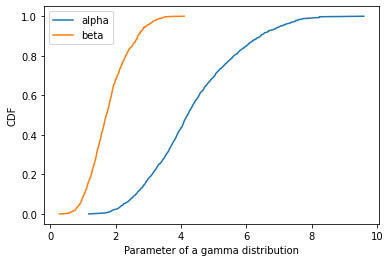

In [112]:
plot_cdf(trace['alpha'], label='alpha')
plot_cdf(trace['beta'], label='beta')

plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
plt.legend();

In [113]:
np.mean(trace['alpha'])

4.379214965370624

In [114]:
np.mean(trace['beta'])

1.7900510372641345

In [115]:
np.mean(trace['alpha'] / trace['beta'])

2.491439604050442

In [116]:
np.mean(trace['alpha'] / trace['beta']**2)

1.6269217027092955